In [59]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
from keras.layers import GRU, Concatenate, MaxPooling2D
from keras.models import Model
from keras.layers import Multiply
from keras.layers import MultiHeadAttention


def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=3)




def DetectionModel():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))
    inception = inception_module(inputs_image,
                                filters_1x1=64,
                                filters_3x3_reduce=96,
                                filters_3x3=128,
                                filters_5x5_reduce=16,
                                filters_5x5=32,
                                filters_pool_proj=32)
    x1 = Conv2D(32, (3, 3), strides = (1, 1), padding='same')(inception)
    x1 = BatchNormalization()(x1)  # BatchNorm 추가
    x1 = Activation('relu')(x1)
    x2 = Conv2D(64, (3, 3), strides = (2, 2), padding='same')(x1)
    x2 = BatchNormalization()(x2)  # BatchNorm 추가
    x2 = Activation('relu')(x2)
    x3 = Conv2D(64, (3, 3), strides = (2, 2), padding='same')(x2)
    x3 = BatchNormalization()(x3)  # BatchNorm 추가
    x3 = Activation('relu')(x3)
    x4 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x3)
    x4 = BatchNormalization()(x4)  # BatchNorm 추가
    x4 = Activation('relu')(x4)
    latent_vector = Flatten()(x4)
    latent_vector = Dense(64)(latent_vector)
    latent_vector = BatchNormalization()(latent_vector)  # BatchNorm 추가
    latent_vector = Activation('relu')(latent_vector)
    # # Decoder 부분 (이미지 재구성)
    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    d1 = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same')(x)
    d1 = BatchNormalization()(d1)  # BatchNorm 추가
    d1 = Activation('relu')(d1)
    
    d2 = Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)  # BatchNorm 추가
    d2 = Activation('relu')(d2)
    d2_output = x3 + d2
    d3 = Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)  # BatchNorm 추가
    d3 = Activation('relu')(d3)
    d3_output = x2 + d3
    d4 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(d3)
    d4 = BatchNormalization()(d4)  # BatchNorm 추가
    d4 = Activation('relu')(d4)
    d4_output = x1 + d4
    
    p4_output = Conv2D(256, 1, 1)(d2_output)
    p5_output = Conv2D(256, 1, 1)(d3_output) 
    p6_output = Conv2D(256, 1, 1)(d4_output) 
    
    p4_output = Conv2D(256, 3, 1, name = 'p4_output')(p4_output)
    p5_output = Conv2D(256, 3, 1, name = 'p5_output')(p5_output)
    p6_output = Conv2D(256, 3, 1, name = 'p6_output')(p6_output)   


    # return Model(inputs_image, [p3_output, p4_output, p5_output])

    return Model(inputs_image, [p4_output, p5_output, p6_output])



In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
from keras.layers import GRU, Concatenate, MaxPooling2D
from keras.models import Model
from keras.layers import Multiply
from keras.layers import MultiHeadAttention
import visualkeras
# strategy = tf.distribute.MirroredStrategy()

# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, concatenate

from keras.layers import ZeroPadding2D
from keras.regularizers import l2

l2_regularizer = l2(0.001)

def STMModel():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))
    
    # inputs_image_norm = inputs_image / 255

    x1 = Conv2D(8, kernel_size=3, strides = 2, padding='same', kernel_regularizer=l2_regularizer)(inputs_image)
    x1 = Activation('relu')(x1)
    # x1 = DepthwiseConv2D(kernel_size=(3, 3))(x1)
    x1 = BatchNormalization()(x1)
    
    x2 = Conv2D(16, kernel_size=3, strides = 2, padding='same', kernel_regularizer=l2_regularizer)(x1)
    x2 = Activation('relu')(x2)
    # x2 = DepthwiseConv2D(kernel_size=(1, 1))(x2)
    x2 = BatchNormalization()(x2)

    x3 = Flatten()(x2)
    latent_vector = Dense(units = 10)(x3)

    x4 = Dense(6 * 8 * 16)(latent_vector)
    x4 = Reshape(target_shape=(6, 8, 16))(x4)

    x5 = Conv2DTranspose(16, kernel_size=3, strides = 1, padding='same', kernel_regularizer=l2_regularizer)(x4)
    x5 = Activation('relu')(x5)
    x5 = concatenate([x5, x2])
    x5 = DepthwiseConv2D(kernel_size=(1, 1))(x5)
    x5 = BatchNormalization()(x5)

    x6 = Conv2DTranspose(8, kernel_size=3, strides = 2, padding='same', kernel_regularizer=l2_regularizer)(x5)
    x6 = Activation('relu')(x6)
    x6 = concatenate([x6, x1])
    x6 = DepthwiseConv2D(kernel_size=(1, 1))(x6)
    x6 = BatchNormalization()(x6)


    # # 분류를 위한 완전 연결 레이어
    latent = keras.layers.GlobalAveragePooling2D()(x6)
    latent= Dense(128, activation='relu', dtype = 'float32')(latent)
    latent = Dropout(0.4)(latent)
    # latent= Dense(64, activation='relu', dtype = 'float32')(latent)
    # latent = Dropout(0.4)(latent)
    # latent= Dense(32, activation='relu', dtype = 'float32')(latent)
    # latent = Dropout(0.4)(latent)
    number_output = Dense(5, activation='softmax', name='number_output', dtype = 'float32')(latent)
    
    model2 = Model(inputs_image, number_output)
    model2.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    # model2 = Model(inputs_image, x6)
    return model2


model2 = STMModel()
model2.summary()

# visualkeras.layered_view(model2, to_file='output.png') # write to disk

2023-12-14 18:06:16.210559: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-14 18:06:16.210583: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-14 18:06:16.210590: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-14 18:06:16.210652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 18:06:16.210690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 16, 8)            80        ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 12, 16, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 12, 16, 8)            32        ['activation[0][0]']          
 Normalization)                                                                               

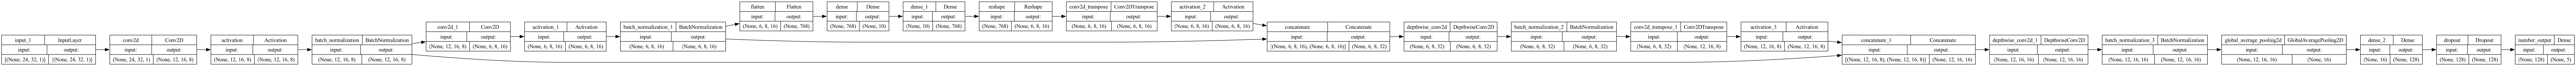

In [5]:
import os
from keras.utils import plot_model
plot_model(model2, to_file='detection_model_v7.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=128)

# 이미지를 표시
Image(filename='detection_model_v7.png')

In [8]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model2)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)



IndexError: list index out of range

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d_336 (Conv2D)         (None, 24, 32, 96)           192       ['input_29[0][0]']            
                                                                                                  
 conv2d_338 (Conv2D)         (None, 24, 32, 16)           32        ['input_29[0][0]']            
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 24, 32, 1)            0         ['input_29[0][0]']            
 ng2D)                                                                                     

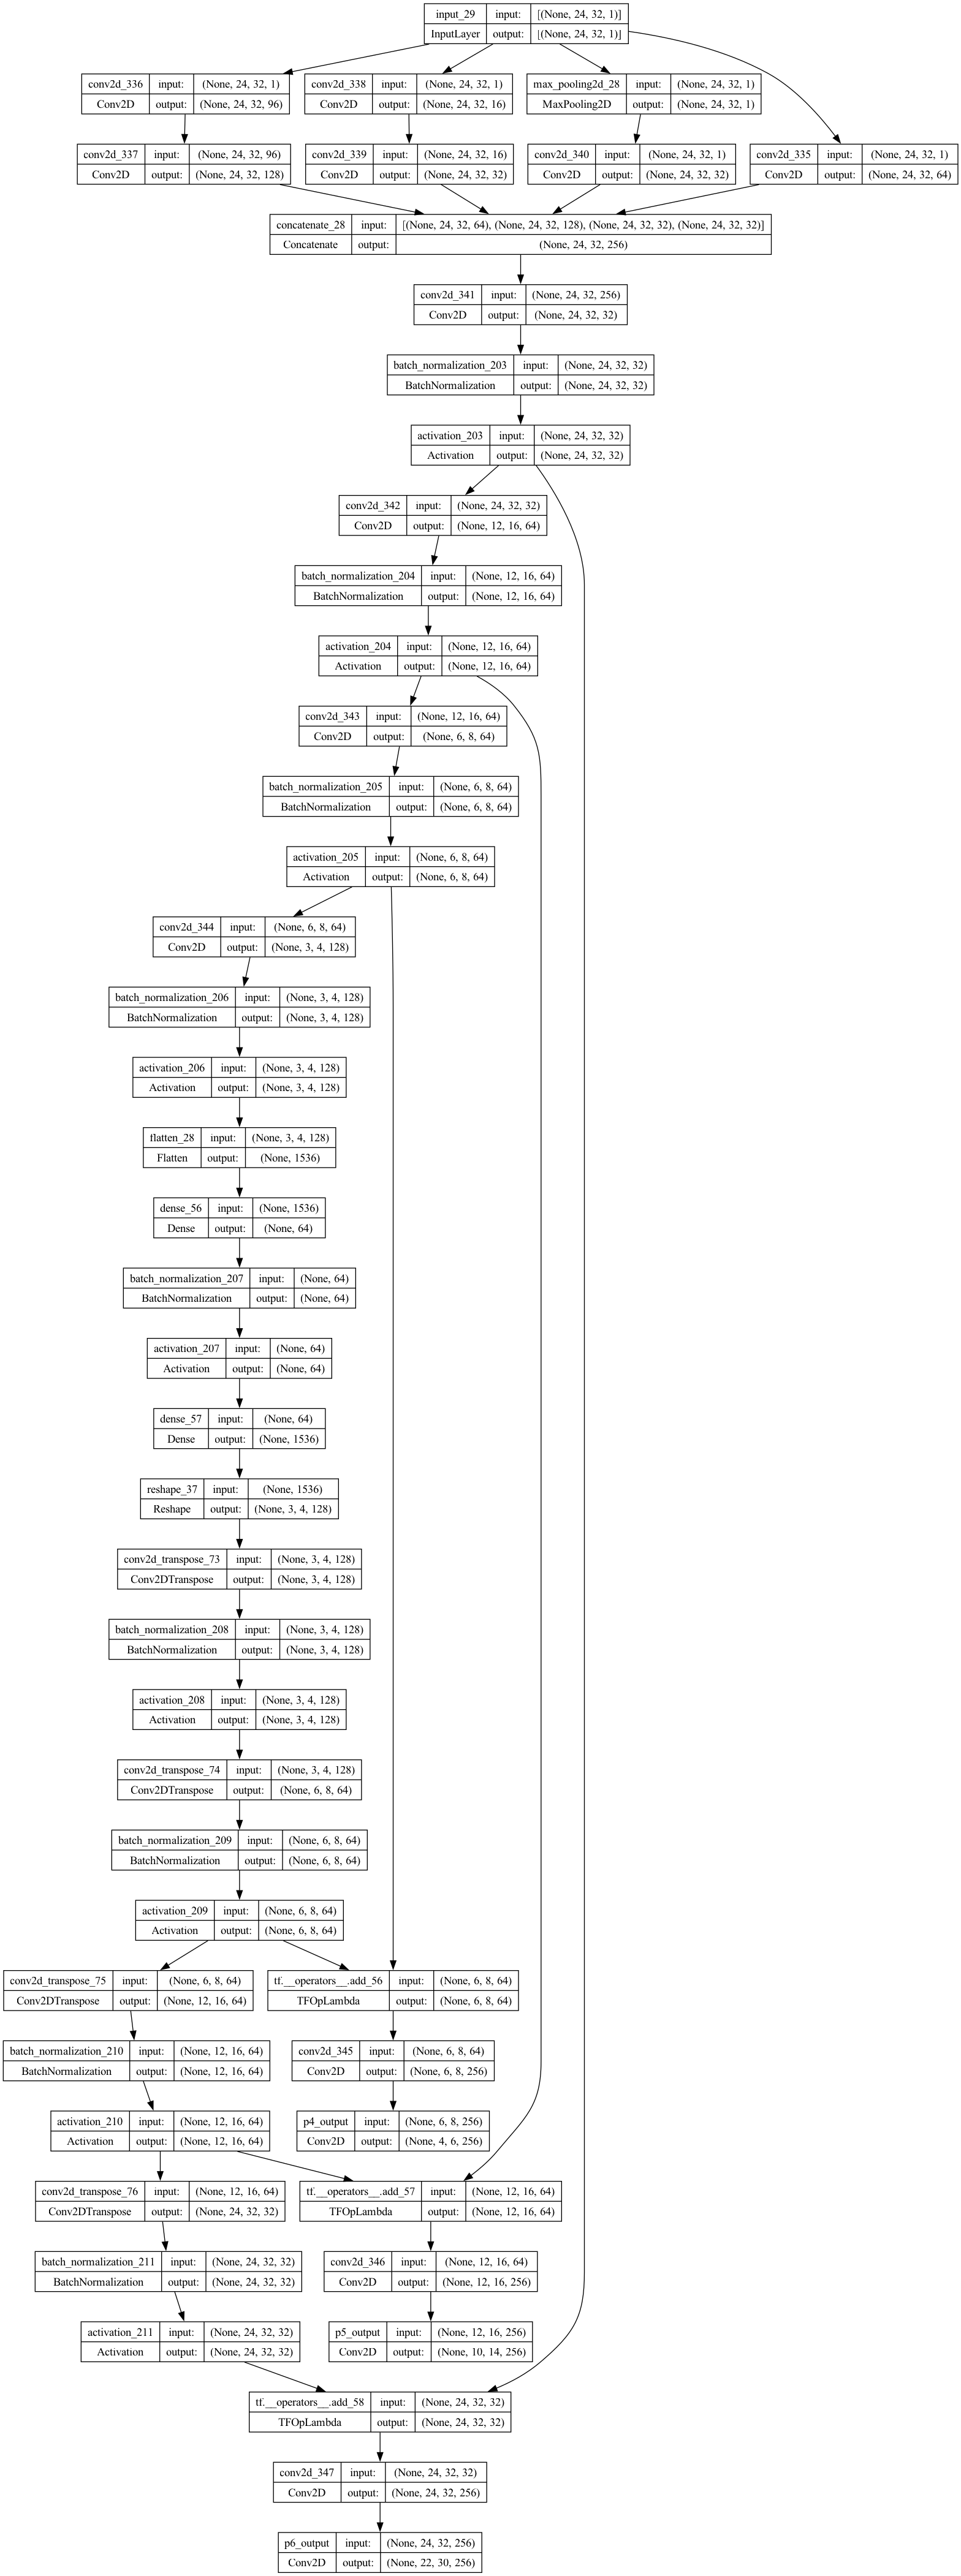

In [60]:
import os
from keras.utils import plot_model

# 모델을 생성
model = DetectionModel()
model.summary()
# 모델을 이미지로 그리고 저장
plot_model(model, to_file='detection_model.png', show_shapes=True, show_layer_names=True)

# 이미지를 표시
Image(filename='detection_model.png')